In [1]:
from transformers import (
    TrainingArguments,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
)

from dataclasses import dataclass, field
from typing import Any, Callable, Dict, List, Optional, Set, Union
from arguments import ModelArguments, DataTrainingArguments

import pathlib
import re
import yaml

import datasets
import pandas as pd
import matplotlib.pyplot as plt 
import librosa


from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
from lang_trans import arabic

In addition to the arguments of the `TrainingArguments` class, custom arguments for the model and the dataset, defined in the arguments.py file, will be used.

I decided to define all the parameters/arguments in three different yaml file, one for each process: 
- For reproducing the paper
- For prediction
- For my training

In this way, all the arguments will be read from this file and it is therefore possible to run the training even from a Windows machine.

In [2]:
# yaml_file = "reproduce.yaml"
# yaml_file = "predict.yaml"
yaml_file = "train.yaml"

# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)

In [3]:
# Arguments
model_args = ModelArguments(**config['model_args'])
data_args = DataTrainingArguments(**config['data_args'])
training_args = TrainingArguments(**config['training_args'])

In [4]:
@dataclass
class Orthography:
    """
    Orthography scheme used for text normalization and tokenization.

    Args:
        do_lower_case (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Whether or not to accept lowercase input and lowercase the output when decoding.
        vocab_file (:obj:`str`, `optional`, defaults to :obj:`None`):
            File containing the vocabulary.
        word_delimiter_token (:obj:`str`, `optional`, defaults to :obj:`"|"`):
            The token used for delimiting words; it needs to be in the vocabulary.
        translation_table (:obj:`Dict[str, str]`, `optional`, defaults to :obj:`{}`):
            Table to use with `str.translate()` when preprocessing text (e.g., "-" -> " ").
        words_to_remove (:obj:`Set[str]`, `optional`, defaults to :obj:`set()`):
            Words to remove when preprocessing text (e.g., "sil").
        untransliterator (:obj:`Callable[[str], str]`, `optional`, defaults to :obj:`None`):
            Function that untransliterates text back into native writing system.
    """

    do_lower_case: bool = False
    vocab_file: Optional[str] = None
    word_delimiter_token: Optional[str] = "|"
    translation_table: Optional[Dict[str, str]] = field(default_factory=dict)
    words_to_remove: Optional[Set[str]] = field(default_factory=set)
    untransliterator: Optional[Callable[[str], str]] = None
    tokenizer: Optional[str] = None

    @classmethod
    def from_name(cls, name: str):
        # Select type of speech corupus
        if name == "librispeech":
            return cls()
        if name == "timit":
            return cls(
                do_lower_case=True,
                # break compounds like "quarter-century-old" and replace pauses "--"
                translation_table=str.maketrans({"-": " "}),
            )
        if name == "buckwalter":
            translation_table = {
                "-": " ",  # sometimes used to represent pauses
                "^": "v",  # fixing "tha" in arabic_speech_corpus dataset
            }
            return cls(
                vocab_file=pathlib.Path(__file__).parent.joinpath("vocab/buckwalter.json"),
                word_delimiter_token="/",  # "|" is Arabic letter alef with madda above
                translation_table=str.maketrans(translation_table),
                words_to_remove={"sil"},  # fixing "sil" in arabic_speech_corpus dataset
                untransliterator=arabic.buckwalter.untransliterate,
            )
        raise ValueError(f"Unsupported orthography: '{name}'.")

    def preprocess_for_training(self, text: str) -> str:
        if len(self.translation_table) > 0:
            text = text.translate(self.translation_table)
        
        if len(self.words_to_remove) == 0:
            try:
                text = " ".join(text.split())  # clean up whitespaces
            except Exception:
                text = "NULL"
        else:
            text = " ".join(w for w in text.split() if w not in self.words_to_remove)  # and clean up whitespaces
        return text

    def create_processor(self, model_args: ModelArguments) -> Wav2Vec2Processor:
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
                                model_args.model_name_or_path, 
                                cache_dir=model_args.cache_dir
                            )
        if self.vocab_file:
            tokenizer = Wav2Vec2CTCTokenizer(
                self.vocab_file,
                cache_dir=model_args.cache_dir,
                do_lower_case=self.do_lower_case,
                word_delimiter_token=self.word_delimiter_token,
            )
        else:
            tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
                self.tokenizer,
                cache_dir=model_args.cache_dir,
                do_lower_case=self.do_lower_case,
                word_delimiter_token=self.word_delimiter_token,
            )
        return Wav2Vec2Processor(feature_extractor, tokenizer)

Feature extractor and tokenizer are wrapped into a `Wav2Vec2Processor` class.

In [5]:
orthography = Orthography.from_name(data_args.orthography.lower())
orthography.tokenizer = model_args.tokenizer
processor = orthography.create_processor(model_args)

C:\Users\flori\miniconda3\envs\DL\lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [6]:
processor

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='facebook/wav2vec2-base', vocab_size=32, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

## Preprocess Data

In [7]:
INPUT_IEMOCAP_FOLDER = "../iemocap"
# SPLIT_ID identifies the test split
SPLIT_ID = data_args.split_id
SPLIT_ID

'01M'

In [8]:
df_train = pd.read_csv(f'{INPUT_IEMOCAP_FOLDER}/iemocap_{SPLIT_ID}.train.csv')
df_val = pd.read_csv(f'{INPUT_IEMOCAP_FOLDER}/iemocap_{SPLIT_ID}.test.csv')

# Change file location to previous folder '../'
df_train['file'] = df_train['file'].map(lambda x: f"../{x}")
df_val['file'] = df_val['file'].map(lambda x: f"../{x}")

Emotion Classes:
- e0: Neutral
- e1: Happy
- e2: Angry
- e3: Sad

In [9]:
if data_args.dataset_name == 'emotion':
    train_dataset = datasets.Dataset.from_pandas(df_train)
    val_dataset = datasets.Dataset.from_pandas(df_val)
    cls_label_map = {"e0":0, "e1":1, "e2":2, "e3":3}

In [10]:
# Target Sampling Rate
target_sr = processor.feature_extractor.sampling_rate if data_args.target_feature_extractor_sampling_rate else None

vocabulary_chars_str = "".join(t for t in processor.tokenizer.get_vocab().keys() if len(t) == 1)
vocabulary_text_cleaner = re.compile(  # remove characters not in vocabulary
    f"[^\s{re.escape(vocabulary_chars_str)}]",  # allow space in addition to chars in vocabulary
    flags=re.IGNORECASE if processor.tokenizer.do_lower_case else 0,
)

In [11]:
text_updates = []

def prepare_sample(sample: datasets.arrow_dataset.Example, audio_only=False):
    # If target_sr is None, the native sampling rate of the file is preserved
    sample["speech"], sample["sampling_rate"] = librosa.load(sample[data_args.speech_file_column], sr=target_sr)
    
    if data_args.max_duration_in_seconds is not None:
        sample["duration_in_seconds"] = len(sample["speech"]) / sample["sampling_rate"]
    
    if audio_only is False:
        # Normalize and clean up text; order matters!
        updated_text = orthography.preprocess_for_training(sample[data_args.target_text_column])
        updated_text = vocabulary_text_cleaner.sub("", updated_text)
        
        if updated_text != sample[data_args.target_text_column]:
            # This list contains the comparison between the original text and the preprocessed one
            text_updates.append((sample[data_args.target_text_column], updated_text))
            sample[data_args.target_text_column] = updated_text
    return sample

In [12]:
if training_args.do_train:
    train_dataset = train_dataset.map(prepare_sample, remove_columns=[data_args.speech_file_column])

if training_args.do_predict:
    val_dataset = val_dataset.map(prepare_sample, fn_kwargs={'audio_only':True})

elif training_args.do_eval:
    val_dataset = val_dataset.map(prepare_sample)

  0%|          | 0/4953 [00:00<?, ?ex/s]

  0%|          | 0/578 [00:00<?, ?ex/s]

In [13]:
# Filter out samples longer in seconds than 'data_args.max_duration_in_seconds'
if data_args.max_duration_in_seconds is not None:
    def filter_by_max_duration(example):
        return example["duration_in_seconds"] <= data_args.max_duration_in_seconds
    
    if training_args.do_train:
        old_train_size = len(train_dataset)
        train_dataset = train_dataset.filter(filter_by_max_duration, remove_columns=["duration_in_seconds"])
        if len(train_dataset) > old_train_size:
            print(
                f"Filtered out {len(train_dataset) - old_train_size} train example(s) longer than {data_args.max_duration_in_seconds} second(s)."
            )
    if training_args.do_predict or training_args.do_eval:
        old_val_size = len(val_dataset)
        val_dataset = val_dataset.filter(filter_by_max_duration, remove_columns=["duration_in_seconds"])
        if len(val_dataset) > old_val_size:
            print(
                f"Filtered out {len(val_dataset) - old_val_size} validation example(s) longer than {data_args.max_duration_in_seconds} second(s)."
            )

In [14]:
# Functions to plot a wordcloud
def plot_wordcloud(text: str, stopwords: set): 
    wordcloud = wc(relative_scaling = 1.0, stopwords=stopwords).generate(text)
    fig,ax = plt.subplots(1, 1, figsize=(15,15))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.show()
    
def generate_wordcloud(text: List[str]):
    eng_stopwords = set(stopwords.words("english"))
    joined_text =" ".join(text)
    plot_wordcloud(joined_text, eng_stopwords)

In [ ]:
train_text = train_dataset['text']
val_text = val_dataset['text']

As we can see from the relevant words, the language used is colloquial, as might be expected in a typical conversation between two people.

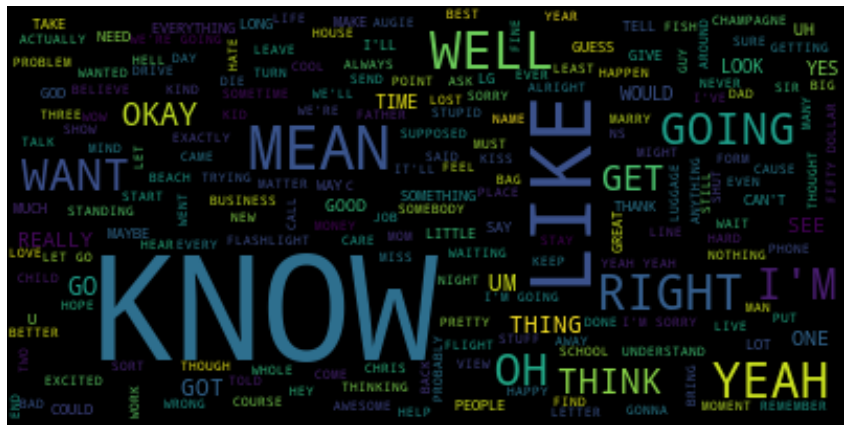

In [16]:
generate_wordcloud(train_text)

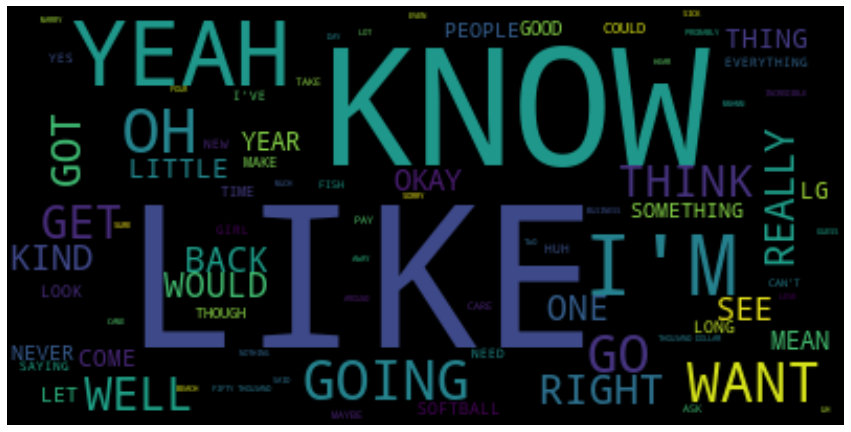

In [17]:
generate_wordcloud(val_text)

## Cleaned Datasets

At this point the datasets are cleaned up and can be further processed to extract features and labels necessary for training. 

We can see that mainly punctuation has been removed from the texts.

In [18]:
start_idx, end_idx = 50, 60
text_updates[start_idx:end_idx]

[('YEAH .', 'YEAH '),
 ("YEAH . WE PLAYED WHEEL OF FORTUNE PENNIES . IT'S LIKE A GIANT THING WITH LIKE .",
  "YEAH  WE PLAYED WHEEL OF FORTUNE PENNIES  IT'S LIKE A GIANT THING WITH LIKE "),
 ('FIFTY BUCKS MMHMM .', 'FIFTY BUCKS MMHMM '),
 ('YEAH .', 'YEAH '),
 ("WELL SO NOW WE'RE MARRIED  WE  HAVE CAT CHILDREN .",
  "WELL SO NOW WE'RE MARRIED WE HAVE CAT CHILDREN "),
 ('WE RENAMED BRENDA  LUMBER JANET .', 'WE RENAMED BRENDA LUMBER JANET '),
 ('SHE NEEDS A NEW NAME EACH STATE THAT WE GO INTO  {LG} .',
  'SHE NEEDS A NEW NAME EACH STATE THAT WE GO INTO LG '),
 ("SO WHAT'S UP WHAT'S NEW .", "SO WHAT'S UP WHAT'S NEW "),
 ('YEAH I HEARD .', 'YEAH I HEARD '),
 ('WHO DID YOU  MARRY .', 'WHO DID YOU MARRY ')]

In [19]:
print(f"Length Train dataset: {train_dataset.shape[0]}")
print(f"Length Valid dataset: {val_dataset.shape[0]}")

Length Train dataset: 4953
Length Valid dataset: 578


In [20]:
val_dataset._data

InMemoryTable
file: string
emotion: string
text: string
speech: list<item: float>
  child 0, item: float
sampling_rate: int64
----
file: [["../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F007.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav",...,"../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M039.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M040.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M041.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.w

The sampling rate is set to 16kHz, as can be seen from the 'sampling_rate' attribute of the dataset, and it is exactly what `Wav2Vec2` expects as an input. 

Now, we extract the `input_values` from the loaded audio files.

In [21]:
def prepare_dataset(batch: datasets.arrow_dataset.Batch, audio_only=False):
    # Check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."
    
    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    if audio_only is False: # Training
        cls_labels = list(map(lambda e: cls_label_map[e], batch["emotion"]))
        
        with processor.as_target_processor(): # Use the tokenizer
            batch["labels"] = processor(batch[data_args.target_text_column]).input_ids
        
        for i in range(len(cls_labels)):
            # Append the emotion label to the end of the list
            batch["labels"][i].append(cls_labels[i]) # batch["labels"] element has to be a single list
    return batch

In [22]:
if training_args.do_train:
    prepared_train_dataset = train_dataset.map(
                        prepare_dataset,
                        batch_size=training_args.per_device_train_batch_size,
                        batched=True,
                        num_proc=data_args.preprocessing_num_workers,
                    )

if training_args.do_predict:
    prepared_val_dataset = val_dataset.map(
                        prepare_dataset,
                        fn_kwargs={'audio_only':True},
                        batch_size=training_args.per_device_eval_batch_size,
                        batched=True,
                        num_proc=data_args.preprocessing_num_workers,
                    )
elif training_args.do_eval:
    prepared_val_dataset = val_dataset.map(
                        prepare_dataset,
                        batch_size=training_args.per_device_eval_batch_size,
                        batched=True,
                        num_proc=data_args.preprocessing_num_workers,
                    )

  0%|          | 0/1239 [00:00<?, ?ba/s]

C:\Users\flori\miniconda3\envs\DL\lib\site-packages\transformers\feature_extraction_utils.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/145 [00:00<?, ?ba/s]

In [23]:
prepared_val_dataset._data

InMemoryTable
file: string
emotion: string
text: string
speech: list<item: float>
  child 0, item: float
sampling_rate: int64
input_values: list<item: float>
  child 0, item: float
labels: list<item: int64>
  child 0, item: int64
----
file: [["../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F007.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav"],["../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F012.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav","../data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F020.wav"],...,["../d

A **label** is made up by two parts:
- Ids related to the tokenized text
- The emotion class id

For instance the label of the first example in the validation set is:

[9, 5, 28, 6, 4, 2]

*i.e.*

**TEXT**

9 -> N

5 -> E

28 -> X

6 -> T

4 -> "empty space"

**EMOTION CLASS**

2 -> e2 (Angry)

Save datasets and processor to the disk.

In this way, you can directly access the preprocess data in the training part and thus save a lot of time.

In [24]:
processor.save_pretrained("datasets/processor")

In [25]:
train_path = f"./datasets/prepared_train_ds/{SPLIT_ID}"
val_path = f"./datasets/prepared_val_ds/{SPLIT_ID}"
prepared_train_dataset.save_to_disk(train_path)
prepared_val_dataset.save_to_disk(val_path)

I noticed that in the training part not all the columns are used, therefore I decided to remove some of them and save also these "reduced" datasets.

In [26]:
reduced_train_dataset = prepared_train_dataset.remove_columns(['speech', 'emotion', 'text', 'sampling_rate'])
reduced_val_dataset = prepared_val_dataset.remove_columns(['speech', 'emotion', 'text', 'sampling_rate'])

train_path = f"./datasets/reduced_train_ds/{SPLIT_ID}"
val_path = f"./datasets/reduced_val_ds/{SPLIT_ID}"
reduced_train_dataset.save_to_disk(train_path)
reduced_val_dataset.save_to_disk(val_path)